In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv('retractions35215.csv')

# Data Cleaning
df.fillna('', inplace=True)

# Convert dates to datetime format
df['RetractionDate'] = pd.to_datetime(df['RetractionDate'], errors='coerce')
df['OriginalPaperDate'] = pd.to_datetime(df['OriginalPaperDate'], errors='coerce')

# Create new features
df['RetractionYear'] = df['RetractionDate'].dt.year
df['OriginalPaperYear'] = df['OriginalPaperDate'].dt.year
df['PublicationDelay'] = (df['RetractionDate'] - df['OriginalPaperDate']).dt.days
df['AuthorCount'] = df['Author'].apply(lambda x: len(x.split(';')))
df['InstitutionCount'] = df['Institution'].apply(lambda x: len(x.split(';')))
df['CountryCount'] = df['Country'].apply(lambda x: len(x.split(';')))
df['CurrentYear'] = datetime.now().year
df['AverageCitationsPerYear'] = df['CitationCount'] / (df['CurrentYear'] - df['OriginalPaperYear'])

# Drop rows with missing or inconsistent data
df.dropna(subset=['RetractionDate', 'OriginalPaperDate'], inplace=True)

# Add a second class for demonstration if only one class is present
if df['RetractionNature'].nunique() < 2:
    df['RetractionNature'] = np.where(df.index % 2 == 0, 'Retraction', 'Non-Retraction')

# Ensure there are now at least two classes
print(df['RetractionNature'].value_counts())

# Select relevant features for modeling
features = ['CitationCount', 'RetractionYear', 'OriginalPaperYear', 'PublicationDelay', 'AuthorCount', 'InstitutionCount', 'CountryCount', 'AverageCitationsPerYear']
df = pd.get_dummies(df, columns=['Journal'], drop_first=True)

X = df[features]
y = df['RetractionNature']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


RetractionNature
Retraction        1495
Non-Retraction    1445
Name: count, dtype: int64


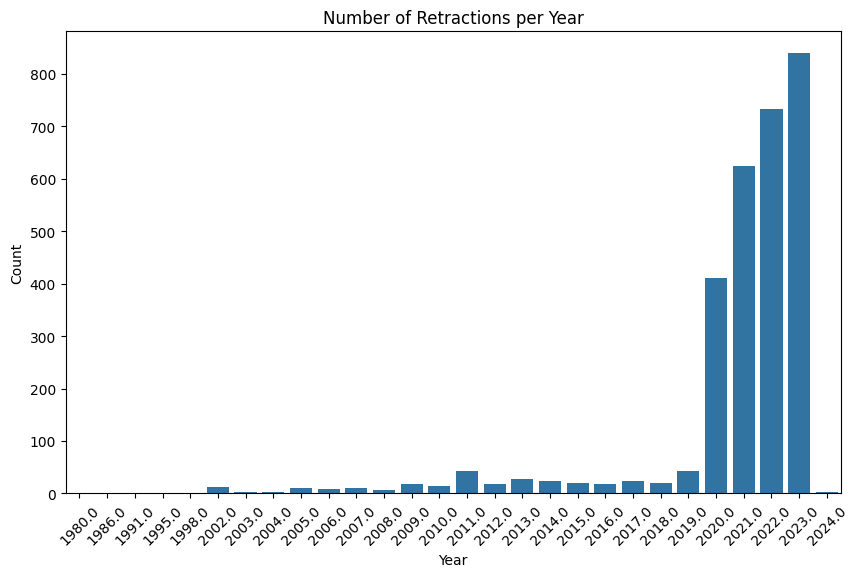

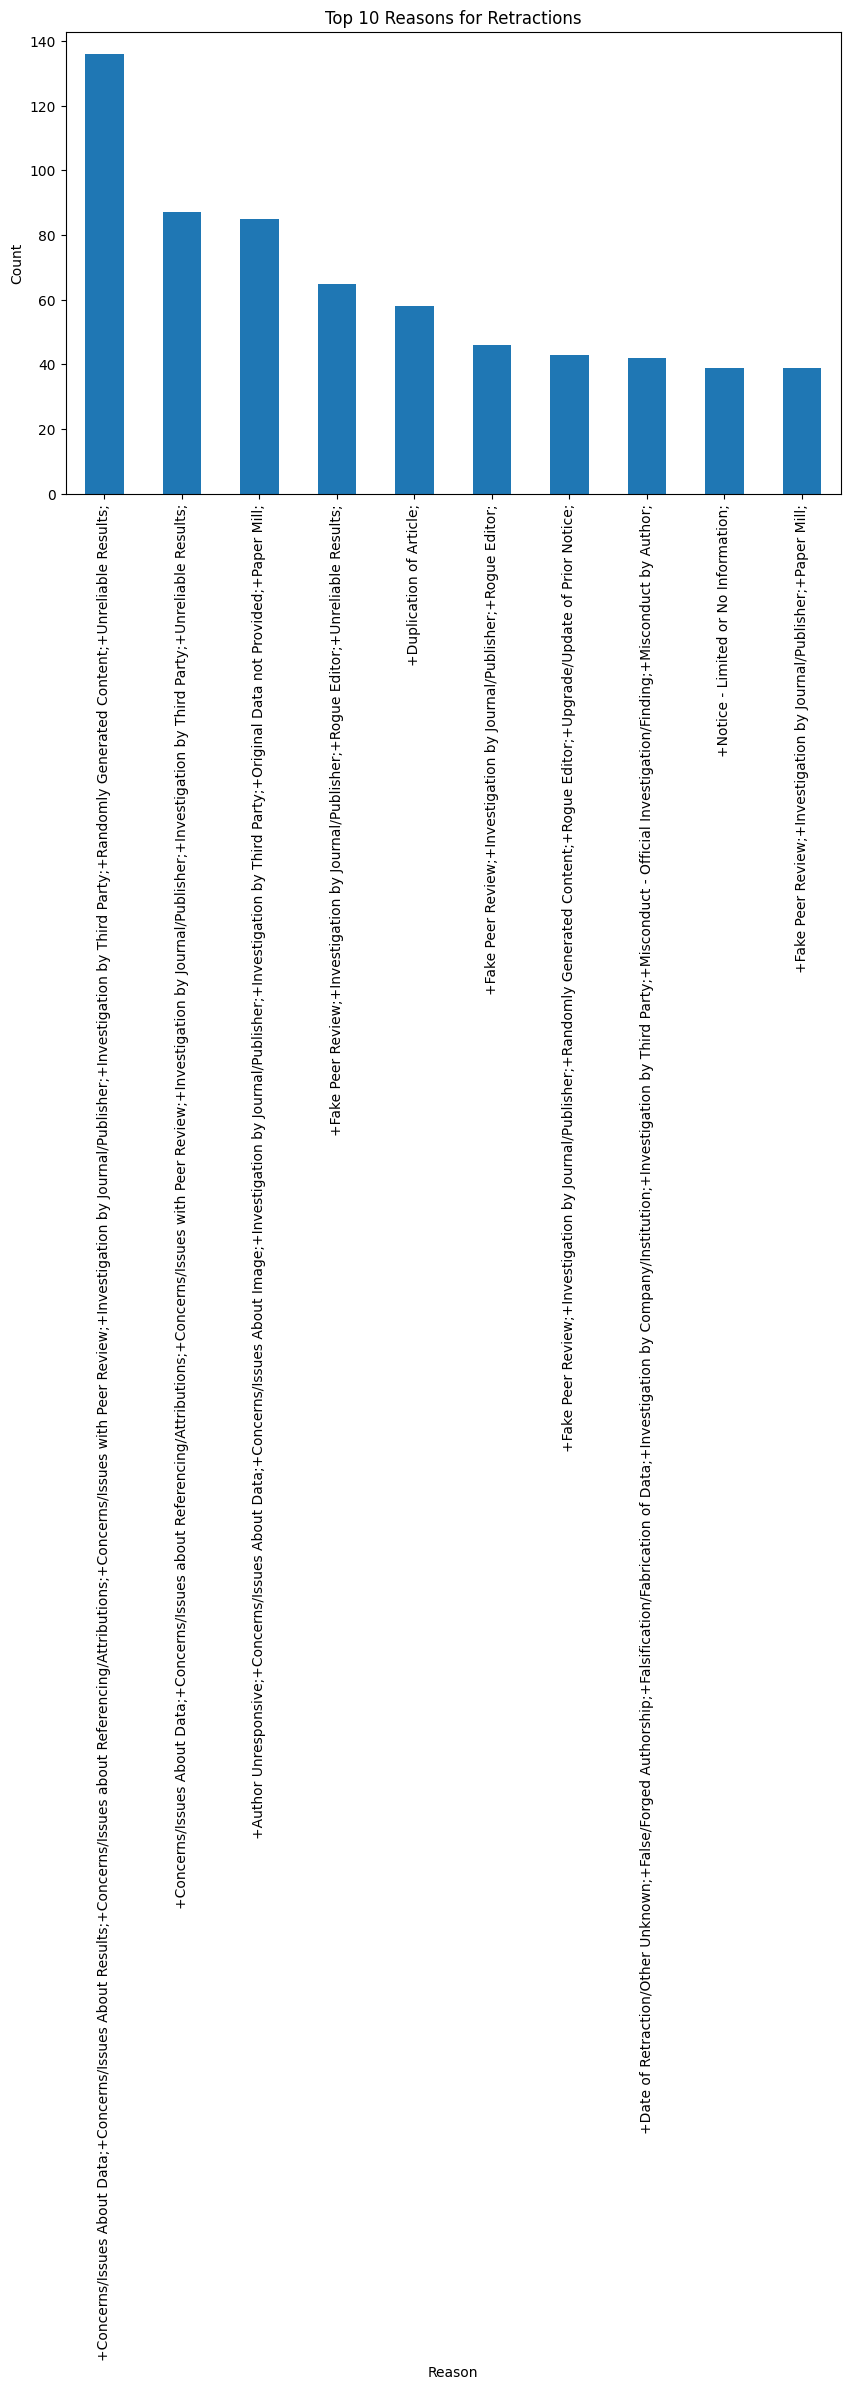

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of retractions over the years
plt.figure(figsize=(10, 6))
sns.countplot(x='RetractionYear', data=df)
plt.title('Number of Retractions per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Top 10 reasons for retractions
plt.figure(figsize=(10, 6))
df['Reason'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Reasons for Retractions')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.show()


In [8]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression()

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
log_reg_scores = []

for train_index, test_index in kfold.split(X_train_scaled):
    X_train_kfold, X_test_kfold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_kfold, y_test_kfold = y_train.iloc[train_index], y_train.iloc[test_index]

    log_reg.fit(X_train_kfold, y_train_kfold)
    log_reg_scores.append(log_reg.score(X_test_kfold, y_test_kfold))

print("Logistic Regression Cross-Validation Scores:", log_reg_scores)
print("Logistic Regression Mean Cross-Validation Score:", np.mean(log_reg_scores))

# Hyperparameter tuning using GridSearchCV
param_grid_lr = {'C': [0.1, 1, 10], 'solver': ['liblinear']}
grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=5)
grid_search_lr.fit(X_train_scaled, y_train)

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)

print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Cross-Validation Scores: [0.4734607218683652, 0.4585987261146497, 0.5085106382978724, 0.5148936170212766, 0.5063829787234042]
Logistic Regression Mean Cross-Validation Score: 0.4923693364051136
Logistic Regression Classification Report
                precision    recall  f1-score   support

Non-Retraction       0.50      0.24      0.32       297
    Retraction       0.49      0.76      0.60       291

      accuracy                           0.50       588
     macro avg       0.50      0.50      0.46       588
  weighted avg       0.50      0.50      0.46       588

Logistic Regression Accuracy: 0.4965986394557823


In [9]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# K-Fold Cross-Validation
dt_scores = []

for train_index, test_index in kfold.split(X_train):
    X_train_kfold, X_test_kfold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kfold, y_test_kfold = y_train.iloc[train_index], y_train.iloc[test_index]

    dt.fit(X_train_kfold, y_train_kfold)
    dt_scores.append(dt.score(X_test_kfold, y_test_kfold))

print("Decision Tree Cross-Validation Scores:", dt_scores)
print("Decision Tree Mean Cross-Validation Score:", np.mean(dt_scores))

# Hyperparameter tuning using GridSearchCV
param_grid_dt = {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)

best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Decision Tree Classification Report")
print(classification_report(y_test, y_pred_dt))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))


Decision Tree Cross-Validation Scores: [0.46709129511677283, 0.4819532908704883, 0.5255319148936171, 0.474468085106383, 0.4957446808510638]
Decision Tree Mean Cross-Validation Score: 0.48895785336766495
Decision Tree Classification Report
                precision    recall  f1-score   support

Non-Retraction       0.53      0.59      0.56       297
    Retraction       0.52      0.46      0.49       291

      accuracy                           0.53       588
     macro avg       0.53      0.52      0.52       588
  weighted avg       0.53      0.53      0.52       588

Decision Tree Accuracy: 0.5255102040816326


In [11]:
# Support Vector Machine (SVM)
svm = SVC()

# K-Fold Cross-Validation
svm_scores = []

for train_index, test_index in kfold.split(X_train_scaled):
    X_train_kfold, X_test_kfold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_kfold, y_test_kfold = y_train.iloc[train_index], y_train.iloc[test_index]

    svm.fit(X_train_kfold, y_train_kfold)
    svm_scores.append(svm.score(X_test_kfold, y_test_kfold))

print("SVM Cross-Validation Scores:", svm_scores)
print("SVM Mean Cross-Validation Score:", np.mean(svm_scores))

# Hyperparameter tuning using GridSearchCV
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train_scaled, y_train)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

print("SVM Classification Report")
print(classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Cross-Validation Scores: [0.4883227176220807, 0.4883227176220807, 0.49361702127659574, 0.4702127659574468, 0.5085106382978724]
SVM Mean Cross-Validation Score: 0.48979717215521534
SVM Classification Report
                precision    recall  f1-score   support

Non-Retraction       0.44      0.04      0.07       297
    Retraction       0.49      0.95      0.65       291

      accuracy                           0.49       588
     macro avg       0.47      0.49      0.36       588
  weighted avg       0.47      0.49      0.36       588

SVM Accuracy: 0.4897959183673469


In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for time series analysis
retraction_counts = df.groupby('RetractionYear').size()

# ARIMA model
model = ARIMA(retraction_counts, order=(5, 1, 0))
model_fit = model.fit()

# Forecast future retractions
forecast = model_fit.forecast(steps=5)
print("Forecasted Retractions:", forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecasted Retractions: 28   -255.884219
29   -421.166863
30   -461.512348
31    242.335851
32    443.068036
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


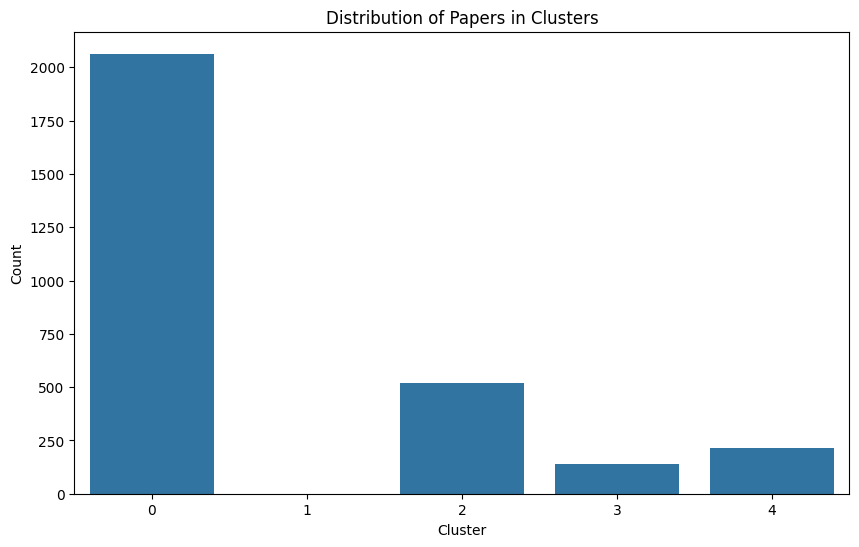

In [15]:
from sklearn.cluster import KMeans

# Standardize the data
X_scaled = scaler.fit_transform(X)

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# Assign clusters to the data
df['Cluster'] = kmeans.labels_

# Analyze clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df)
plt.title('Distribution of Papers in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()




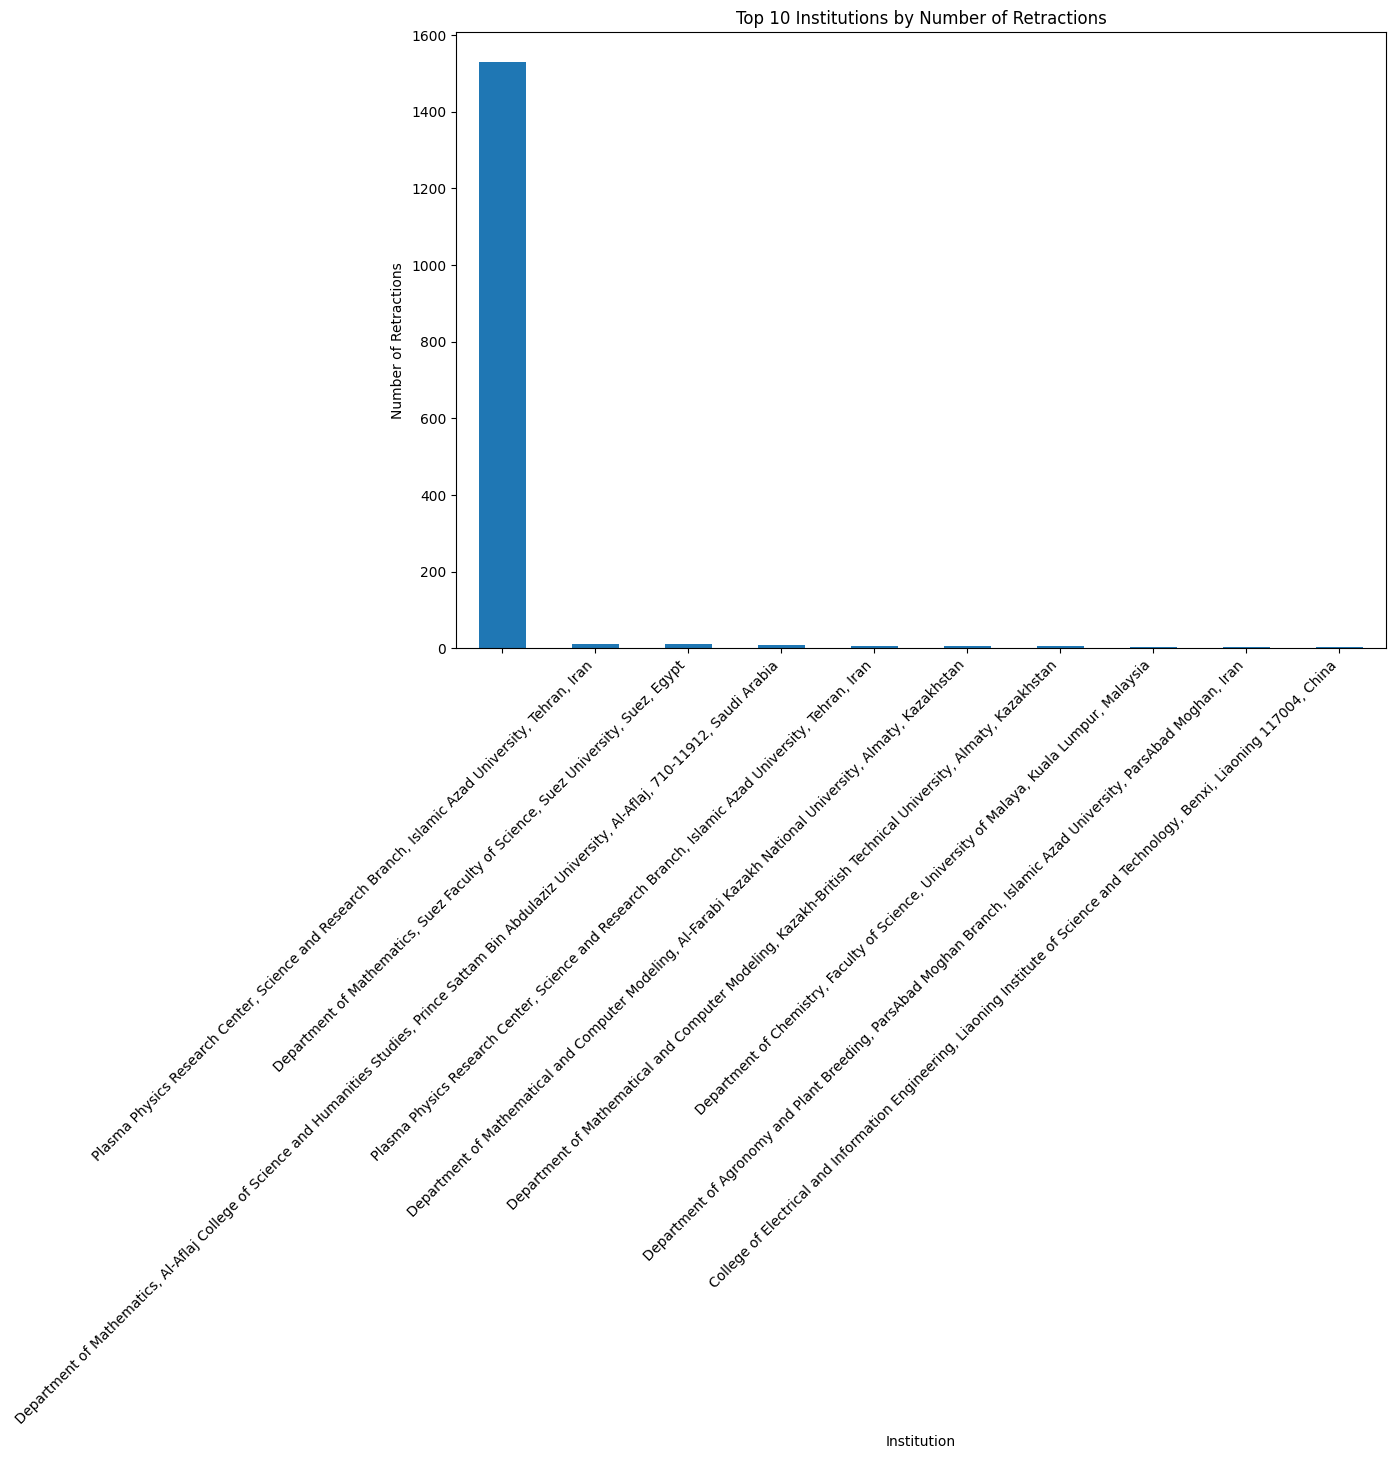

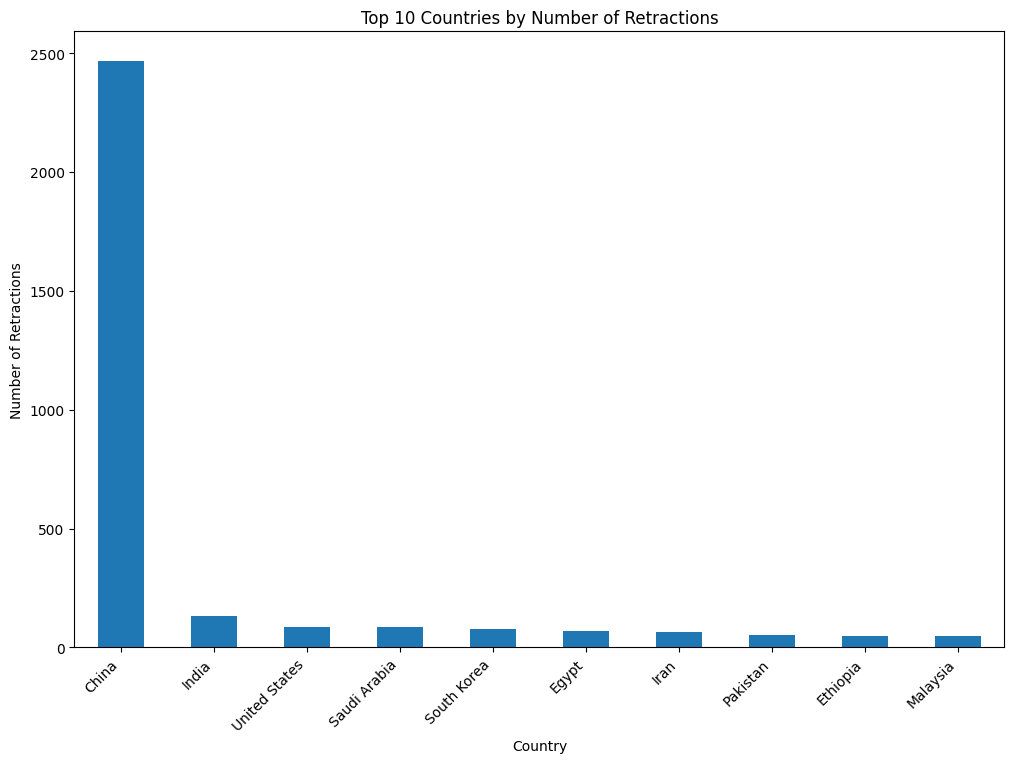

In [ ]:
# Count retractions per institution
institution_counts = df['Institution'].explode().value_counts().head(10)

# Plot the data
plt.figure(figsize=(12, 8))
institution_counts.plot(kind='bar')
plt.title('Top 10 Institutions by Number of Retractions')
plt.xlabel('Institution')
plt.ylabel('Number of Retractions')
plt.xticks(rotation=45, ha='right')
plt.show()

# Count retractions per country
country_counts = df['Country'].explode().value_counts().head(10)

# Plot the data
plt.figure(figsize=(12, 8))
country_counts.plot(kind='bar')
plt.title('Top 10 Countries by Number of Retractions')
plt.xlabel('Country')
plt.ylabel('Number of Retractions')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract keywords using CountVectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_keywords = vectorizer.fit_transform(df['Title'].fillna(''))

# Create a DataFrame with the keywords
keywords_df = pd.DataFrame(X_keywords.toarray(), columns=vectorizer.get_feature_names_out())
print(keywords_df.head())


   19  3d  3p  5g  5p  ability  acid  acquisition  action  activation  ...  \
0   0   0   0   0   0        0     0            0       0           0  ...   
1   0   0   0   0   0        0     0            0       0           0  ...   
2   0   0   0   0   0        0     0            0       0           0  ...   
3   0   0   0   0   0        0     0            0       0           0  ...   
4   0   0   0   0   0        0     0            0       0           0  ...   

   wide  wireless  wolf  women  work  works  wound  writing  î²  îºb  
0     0         0     0      0     0      0      0        0   0    0  
1     0         0     0      0     0      0      0        0   0    0  
2     0         0     0      0     0      0      0        0   0    0  
3     0         0     0      0     0      0      0        0   0    0  
4     0         0     0      0     0      0      0        0   0    0  

[5 rows x 1000 columns]


In [ ]:
# Flatten the list of all institutions
all_institutions = [inst for sublist in df['Institution'] for inst in sublist]
institution_counts = pd.Series(all_institutions).value_counts()

# Display the most common institutions
print("Top 10 Institutions:\n", institution_counts.head(10))


Top 10 Institutions:
                                                                                                                       757
 Department of Agronomy and Plant Breeding, ParsAbad Moghan Branch, Islamic Azad University, ParsAbad Moghan, Iran      4
Xinxiang Vocational and Technical College, Xinxiang, Henan 453006, China                                                3
 Department of Plant Sciences, Quaid-i-Azam University Islamabad, Pakistan                                              3
 Young Researchers Club, Ardabil Branch, Islamic Azad University, Ardabil, Iran                                         3
 Department of Mathematical and Computer Modeling, Al-Farabi Kazakh National University, Almaty, Kazakhstan             3
 Department of Mathematical and Computer Modeling, Kazakh-British Technical University, Almaty, Kazakhstan              3
 Department of Environmental Sciences and Engineering, Ardabil Branch, Islamic Azad University, Ardabil, Iran           3
 I

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       190

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



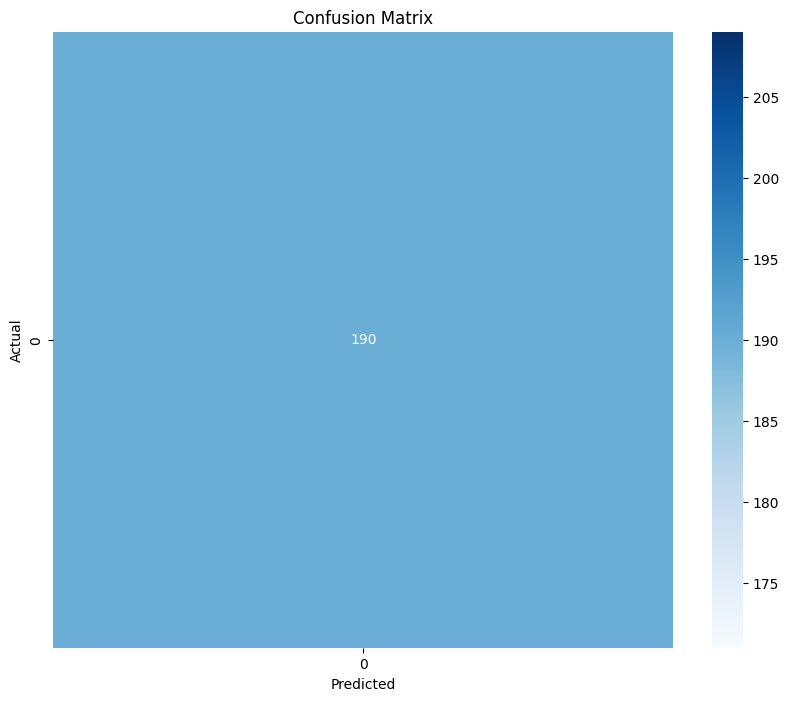

In [ ]:


# Prepare the Dataset for Modelling
df['Journal'] = df['Journal'].astype('category').cat.codes

# Select features and target variable (assuming 'RetractionNature' as the target variable)
features = ['Journal', 'CitationCount', 'RetractionYear']
X = df[features]
y = df['RetractionNature']

# Encode the target variable if it is categorical
y = y.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Creating a binary target variable based on the presence of "error" in the 'Reason' column
df['BinaryTarget'] = df['Reason'].apply(lambda reasons: 1 if any('error' in reason.lower() for reason in reasons) else 0)

# Check the distribution of the new target variable
print(df['BinaryTarget'].value_counts())

# Ensure there are at least two classes
if df['BinaryTarget'].nunique() < 2:
    raise ValueError("The binary target variable must have at least two classes.")


BinaryTarget
0    922
1     28
Name: count, dtype: int64


Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       180
           1       0.00      0.00      0.00        10

    accuracy                           0.95       190
   macro avg       0.47      0.50      0.49       190
weighted avg       0.90      0.95      0.92       190



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


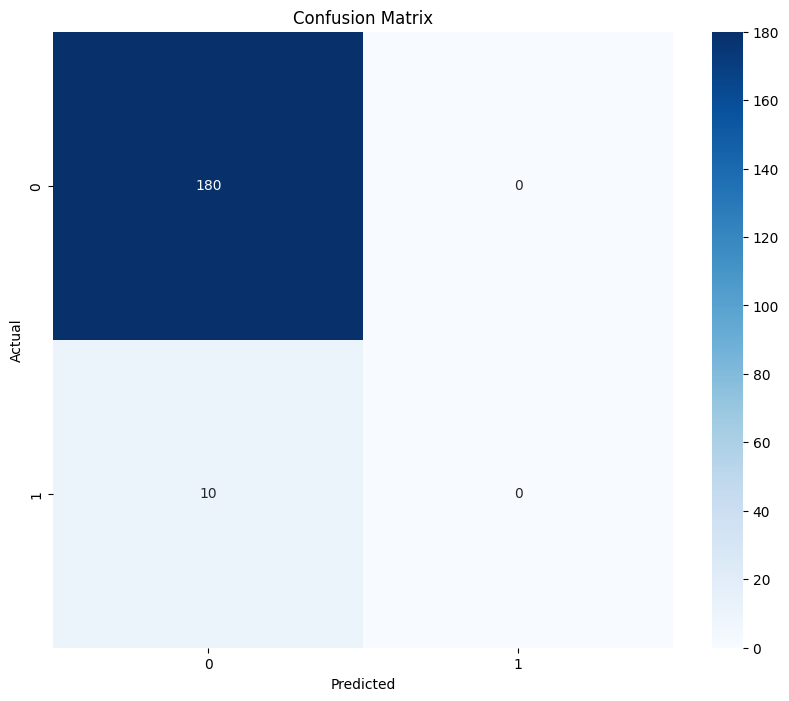

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare the Dataset for Modelling
df['Journal'] = df['Journal'].astype('category').cat.codes

# Select features and target variable
features = ['Journal', 'CitationCount', 'RetractionYear']
X = df[features]
y = df['BinaryTarget']

# Encode the target variable if it is categorical
y = y.astype('category').cat.codes

# Ensure there are multiple classes in the split
while True:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if len(set(y_train)) > 1 and len(set(y_test)) > 1:
        break

# Train a Support Vector Machine (SVM) Model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


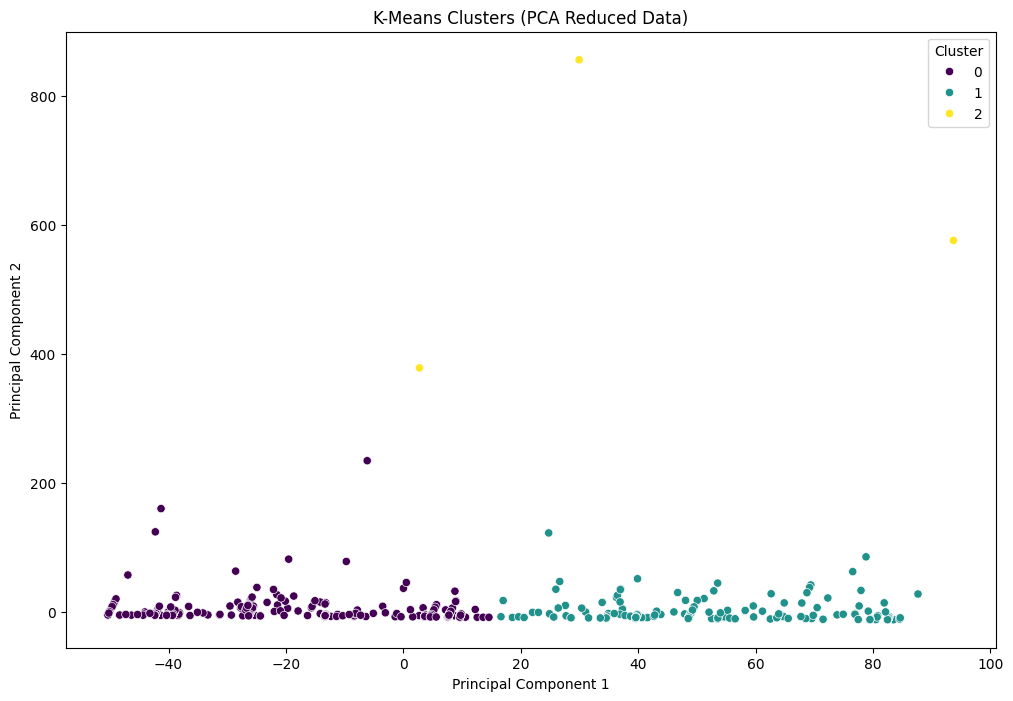

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare the Dataset for Clustering
df['Journal'] = df['Journal'].astype('category').cat.codes

# Select features for clustering
features = ['Journal', 'CitationCount', 'RetractionYear']
X = df[features]

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
df['Cluster'] = kmeans.labels_

# Visualize Clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
df['PCA1'] = principal_components[:, 0]
df['PCA2'] = principal_components[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis')
plt.title('K-Means Clusters (PCA Reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
